#I. Load the dataset and necessary libraries

In [38]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [39]:
!pip install kneed

In [40]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from kneed import KneeLocator
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.manifold import TSNE
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import pairwise_distances

In [41]:
dataset = pd.read_csv('/content/drive/MyDrive/Spotify_project/Data/spotify_data.csv')
filtered_dataset = dataset[
    (dataset['duration_ms'] >= 90000) &
    (dataset['duration_ms'] <= 420000) &
    (dataset['popularity'] > 20)
]
spotify_mil = filtered_dataset.drop(columns = ['Unnamed: 0', 'track_id', 'duration_ms', 'mode', 'key','time_signature', 'liveness']).reset_index(drop = True)
display(spotify_mil.head())

,artist_name,track_name,popularity,year,genre,danceability,energy,loudness,speechiness,acousticness,instrumentalness,valence,tempo
0,Jason Mraz,I Won't Give Up,68,2012,acoustic,0.483,0.303,-10.058,0.0429,0.6940,0.000000,0.139,133.406
1,Jason Mraz,93 Million Miles,50,2012,acoustic,0.572,0.454,-10.286,0.0258,0.4770,0.000014,0.515,140.182
2,Joshua Hyslop,Do Not Let Me Go,57,2012,acoustic,0.409,0.234,-13.711,0.0323,0.3380,0.000050,0.145,139.832
3,Boyce Avenue,Fast Car,58,2012,acoustic,0.392,0.251,-9.845,0.0363,0.8070,0.000000,0.508,204.961
4,Andrew Belle,Sky's Still Blue,54,2012,acoustic,0.430,0.791,-5.419,0.0302,0.0726,0.019300,0.217,171.864


I filtered out too short songs (duration < 90,000 mili seconds, or 1:30 minutes) and too long songs ( duration > 420,000 mili seconds, or 7 minutes). For better quality and smaller-sized data set, I will choose popularity > 20 as the threshold.

First, I will drop some unnecessary columns for this task, namely Unnamed: 0(basically the index), track_id, and duration of the song.
- The 'mode' is a binary variable => not good for a distance-based algorithm like Kmeans, and it is not important in determining the mood => exclude
-'liveness' is the presence of audience in the recording => indicating whether the song is a live performance or not => not related to mood => exclude
- Although 'key' and 'time_signature' might be helpful to some extent, they are highly related to the genre and sheet music instead of the actual mood. Therefore, to minimize the risk of noise in our model, I won't use those musical features.
- 'popularity' will be used as an option to sort the recommended playlist

#II. Exploratory Data Analysis

In [42]:
basic_eda = pd.DataFrame({
    'Data Type': spotify_mil.dtypes,
    'Unique Values': spotify_mil.nunique(),
    'Missing Values': spotify_mil.isna().sum()
})
basic_eda = basic_eda.sort_values(by='Missing Values', ascending=False)
basic_eda

,Data Type,Unique Values,Missing Values
artist_name,object,45596,3
track_name,object,329641,0
popularity,int64,77,0
year,int64,24,0
genre,object,82,0
danceability,float64,1318,0
energy,float64,2821,0
loudness,float64,31242,0
speechiness,float64,1607,0
acousticness,float64,5397,0


There are only a few missing values, so we can handle by dropping those values.

In [43]:
spotify_mil = spotify_mil.dropna()

##1. Genre Selection

In [44]:
spotify_mil['genre'].unique()

array(['acoustic', 'afrobeat', 'alt-rock', 'ambient', 'black-metal',
       'blues', 'breakbeat', 'cantopop', 'chill', 'classical', 'club',
       'comedy', 'country', 'dance', 'dancehall', 'death-metal',
       'deep-house', 'detroit-techno', 'disco', 'drum-and-bass', 'dub',
       'edm', 'electro', 'electronic', 'emo', 'folk', 'forro', 'french',
       'funk', 'garage', 'german', 'gospel', 'goth', 'grindcore',
       'groove', 'guitar', 'hard-rock', 'hardcore', 'hardstyle',
       'heavy-metal', 'hip-hop', 'house', 'indian', 'indie-pop',
       'industrial', 'jazz', 'k-pop', 'metal', 'metalcore',
       'minimal-techno', 'new-age', 'opera', 'party', 'piano', 'pop',
       'pop-film', 'power-pop', 'progressive-house', 'psych-rock', 'punk',
       'punk-rock', 'rock', 'rock-n-roll', 'sad', 'salsa', 'samba',
       'sertanejo', 'show-tunes', 'singer-songwriter', 'ska', 'sleep',
       'soul', 'spanish', 'swedish', 'tango', 'techno', 'trance',
       'trip-hop', 'chicago-house', 'romance

I spent time listening to some strange genres and realized that a lot of them need some minor changes:
- comedy is spoken words => exclude
- show-tunes is a scene in a play (no music, just spoken words) => exclude
- party, weirdly, is all songs and audio stories for kids (If you're happy and you know it clap your hand, Red Riding Hood (fairy tales), etc) => exclude
- romance is all Russian songs, so I will rename this genre to 'russian'
- pop-film is Indian movies' soundtracks, so I merge it together with 'indian'.
- Also, I will group similar genres into one big genre. I will capitalize each genre name for better visual effect.

In [45]:
genres_to_exclude = ['comedy', 'show-tunes', 'party']
spotify_mil = spotify_mil[~spotify_mil['genre'].isin(genres_to_exclude)]
spotify_mil['genre'] = spotify_mil['genre'].replace({
    'romance': 'Russian',
    'pop-film': 'Indian',
    'acoustic': 'Acoustic',
    'groove': 'Groove',
    'hip-hop': 'Hip-hop',
    'blues': 'Blues',
    'french': 'French',
    'german': 'German',
    'swedish': 'Swedish',
    'spanish': 'Spanish',
    'sad': 'Sad',
    'indian': 'Indian',
    'funk': 'Funk',
    'country': 'Country',
    'jazz': 'Jazz',
    'gospel': 'Gospel'
})

In [46]:
genre_map = {
    'Rock': ['alt-rock', 'emo', 'garage', 'psych-rock', 'punk', 'punk-rock', 'rock', 'rock-n-roll', 'hard-rock'],
    'Pop': ['pop', 'k-pop', 'power-pop', 'dance', 'cantopop', 'indie-pop'],
    'Urban': [ 'afrobeat', 'soul', 'dancehall'],
    'Electronic': ['electronic', 'dub', 'edm', 'electro', 'club', 'disco', 'trance', 'trip-hop', 'dubstep', 'breakbeat','drum-and-bass'],
    'Techno': ['techno', 'minimal-techno', 'detroit-techno'],
    'House': ['house', 'deep-house', 'progressive-house', 'chicago-house'],
    'Metal': ['metal', 'heavy-metal', 'black-metal', 'death-metal', 'grindcore', 'hardcore', 'metalcore', 'industrial', 'goth', 'hardstyle'],
    'Composer': ['singer-songwriter', 'songwriter'],
    'Instrumental': ['piano', 'guitar', 'new-age'],
    'Classical Music': ['classical', 'opera'],
    'Cultural Music': ['folk', 'sertanejo', 'samba', 'tango', 'salsa', 'forro', 'ska'],
    'Relax': ['sleep', 'chill', 'ambient']
}
keep_as_is = ['Acoustic', 'Groove', 'Hip-hop', 'Blues', 'Russian', 'French', 'German', 'Swedish','Spanish', 'Sad', 'Indian','Funk', 'Country', 'Jazz', 'Gospel']
genre_lookup = {}
for group, genres in genre_map.items():
    for genre in genres:
        genre_lookup[genre] = group
def assign_genre_group(genre):
    if genre in keep_as_is:
        return genre
    return genre_lookup.get(genre, 'other')
spotify_mil['genre'] = spotify_mil['genre'].map(assign_genre_group)


In [47]:
spotify_mil['genre'].value_counts()

,count
genre,
Rock,58105
Pop,45413
Electronic,40657
Metal,38103
Cultural Music,35222
Relax,23898
Hip-hop,15132
Country,14293
Urban,13404


##2. Feature Selection

Since it is not a regression task, it's impossible to use some feature selection methods such as lasso and ridge. I will try to check correlation between each pair of features, detect multicollinearity by using VIF, and identify features with low variance/skew distribution/different range.

###2.1 Correlation Matrix

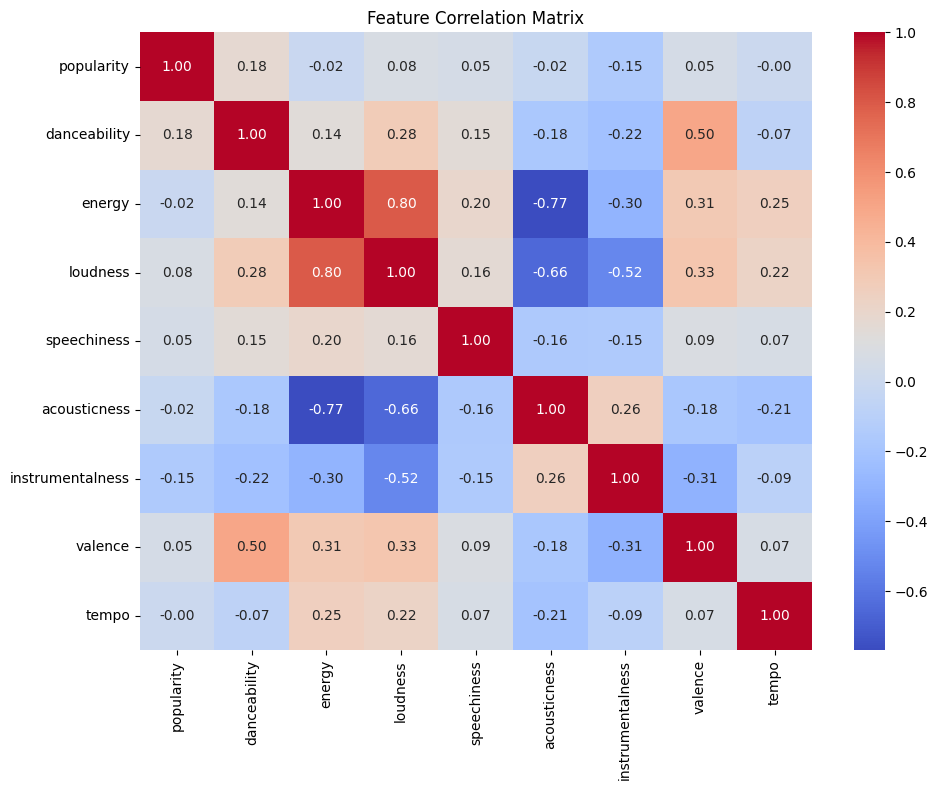

In [48]:
X = spotify_mil.select_dtypes(include='number').drop(columns=['track_name', 'artists_name','genre', 'year'], errors='ignore')
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
plt.figure(figsize=(10, 8))
sns.heatmap(X_scaled_df.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.show()

In [49]:
corr_matrix = X_scaled_df.corr().abs()
mask = np.tril(np.ones(corr_matrix.shape), k=0).astype(bool)
corr_matrix_masked = corr_matrix.mask(mask)
corr_pairs = corr_matrix_masked.unstack().dropna()
top3_corr = corr_pairs.sort_values(ascending=False).head(3)
print("Top 3 highest correlated feature pairs:")
print(top3_corr)

Top 3 highest correlated feature pairs:
loudness      energy      0.795183
acousticness  energy      0.769668
              loudness    0.656182
dtype: float64


There is a high positive correlation between loudness and energy, so I will use PCA (Principal Component Analysis) to combine them into one feature.

In [50]:
energy_loudness = X_scaled_df[['energy', 'loudness']]
pca = PCA(n_components=1)
combined_feature = pca.fit_transform(energy_loudness)
X_scaled_df['energy_loudness_pca'] = combined_feature.flatten()
X_scaled_df = X_scaled_df.drop(columns=['energy', 'loudness'])

In [51]:
spotify_mil['energy_loudness_pca'] = X_scaled_df['energy_loudness_pca'].values
spotify_mil = spotify_mil.drop(columns=['energy', 'loudness'])
spotify_mil

,artist_name,track_name,popularity,year,genre,danceability,speechiness,acousticness,instrumentalness,valence,tempo,energy_loudness_pca
0,Jason Mraz,I Won't Give Up,68,2012,Acoustic,0.483,0.0429,0.69400,0.000000,0.139,133.406,-1.182718
1,Jason Mraz,93 Million Miles,50,2012,Acoustic,0.572,0.0258,0.47700,0.000014,0.515,140.182,-0.799411
2,Joshua Hyslop,Do Not Let Me Go,57,2012,Acoustic,0.409,0.0323,0.33800,0.000050,0.145,139.832,-1.842104
3,Boyce Avenue,Fast Car,58,2012,Acoustic,0.392,0.0363,0.80700,0.000000,0.508,204.961,-1.297385
4,Andrew Belle,Sky's Still Blue,54,2012,Acoustic,0.430,0.0302,0.07260,0.019300,0.217,171.864,0.748897
...,...,...,...,...,...,...,...,...,...,...,...,...
428784,Mo' Horizons,Around Ya feat. Fuel Fandango,24,2011,Electronic,0.801,0.0527,0.26100,0.001030,0.805,112.034,0.503976
428785,GusGus,Be With Me Now,21,2011,Electronic,0.406,0.1850,0.59000,0.605000,0.436,176.967,-1.132598
428786,GusGus,Magnified Love,21,2011,Electronic,0.914,0.2590,0.45300,0.151000,0.493,117.993,-0.654719
428787,Röyksopp,Eple 2003,23,2011,Electronic,0.672,0.0491,0.00242,0.112000,0.827,106.483,0.296089


###2.2 VIF Test

In [52]:
vif_data = pd.DataFrame()
vif_data["feature"] = X_scaled_df.columns
vif_data["VIF"] = [variance_inflation_factor(X_scaled_df.values, i) for i in range(X_scaled_df.shape[1])]
vif_data = vif_data.sort_values(by="VIF", ascending=False)
vif_data

,feature,VIF
7,energy_loudness_pca,2.923516
3,acousticness,2.383694
5,valence,1.499013
1,danceability,1.438371
4,instrumentalness,1.332249
6,tempo,1.095940
2,speechiness,1.057959
0,popularity,1.055616


There is no feature with VIF score > 5 => no multicollinearity detected.

###2.3 Distribution and Variance Check

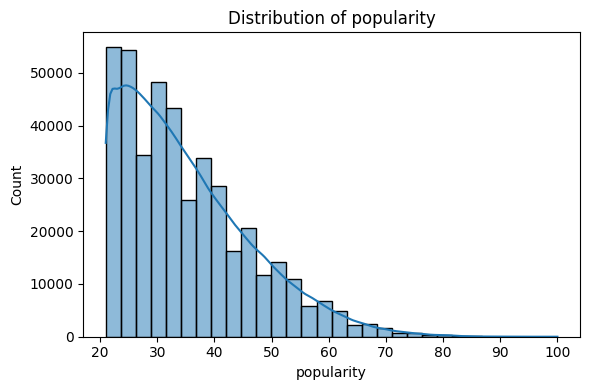

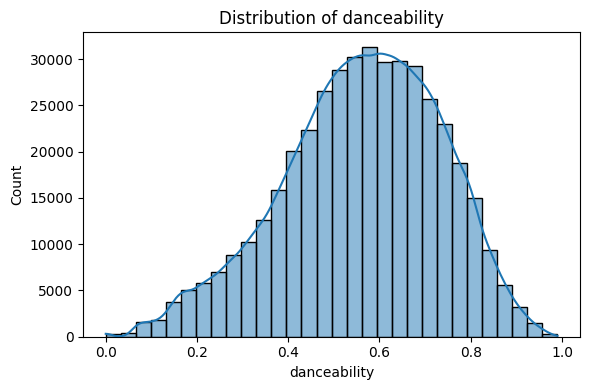

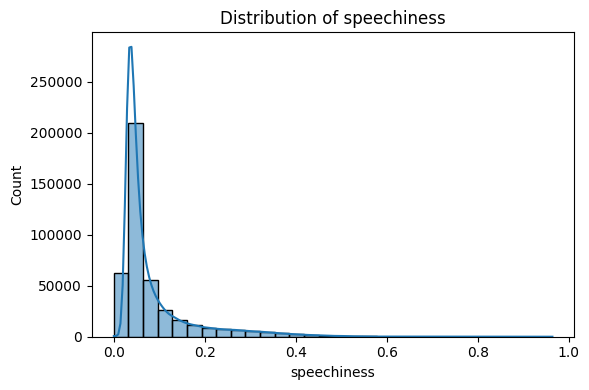

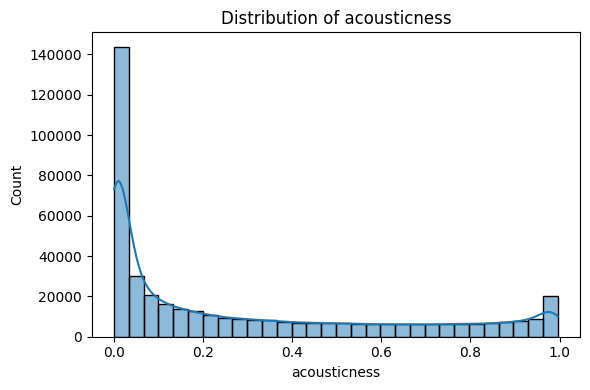

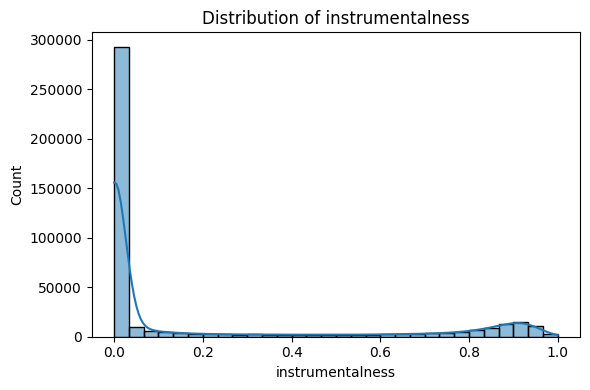

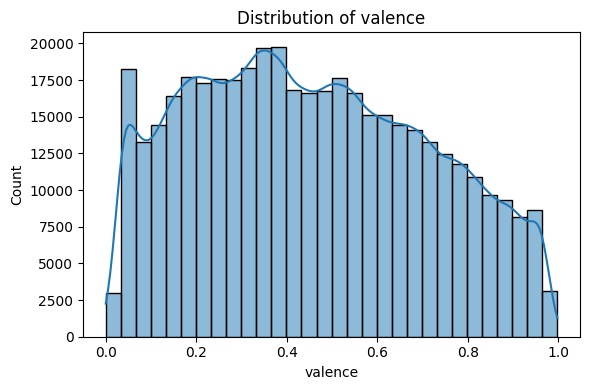

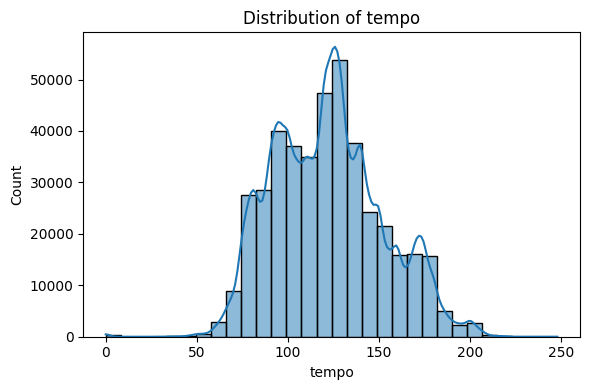

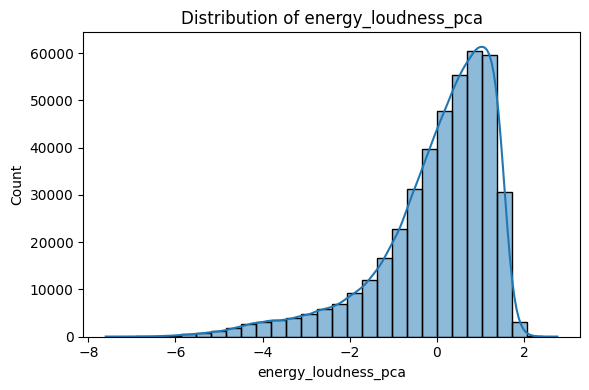

In [17]:
excluded_cols = ['track_name', 'artists_name','genre','year']
features_eda = [col for col in spotify_mil.columns if col not in excluded_cols]
features_eda = spotify_mil[features_eda].select_dtypes(include='number').columns
for feature in features_eda:
    plt.figure(figsize=(6, 4))
    sns.histplot(spotify_mil[feature], kde=True, bins=30)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

Based on the plots, we now identified some key issues:
- Different range=> need to transform to (0,1): tempo, energy_loudness_pca
- Highly skewed: speechiness => won't include in Kmeans since I don't think it is importance for the mood/vibe.
- Heavily skewed with many 0s: instrumentalness and acousticness. For instrumentalness, a song with high instrumentalness but low valence and high energy can be categorised into "intense" mood, so I will keep it for the model. For acousticness, I think it is really important for certain moods such as chill, so I will also keep it.   

#III. Feature Engineering

##1. Scale to (0,1)

In [53]:
features_to_scale = spotify_mil[['tempo', 'energy_loudness_pca']]
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features_to_scale)
scaled_df = pd.DataFrame(scaled_features, columns=['tempo_scaled', 'energy_loudness_pca_scaled'], index=spotify_mil.index)
spotify_mil['tempo_scaled'] = scaled_df['tempo_scaled']
spotify_mil['energy_loudness_pca_scaled'] = scaled_df['energy_loudness_pca_scaled']
spotify_mil = spotify_mil.drop(columns=['tempo', 'energy_loudness_pca'], errors='ignore')
spotify_mil

,artist_name,track_name,popularity,year,genre,danceability,speechiness,acousticness,instrumentalness,valence,tempo_scaled,energy_loudness_pca_scaled
0,Jason Mraz,I Won't Give Up,68,2012,Acoustic,0.483,0.0429,0.69400,0.000000,0.139,0.537886,0.619082
1,Jason Mraz,93 Million Miles,50,2012,Acoustic,0.572,0.0258,0.47700,0.000014,0.515,0.565207,0.656058
2,Joshua Hyslop,Do Not Let Me Go,57,2012,Acoustic,0.409,0.0323,0.33800,0.000050,0.145,0.563796,0.555473
3,Boyce Avenue,Fast Car,58,2012,Acoustic,0.392,0.0363,0.80700,0.000000,0.508,0.826392,0.608021
4,Andrew Belle,Sky's Still Blue,54,2012,Acoustic,0.430,0.0302,0.07260,0.019300,0.217,0.692947,0.805419
...,...,...,...,...,...,...,...,...,...,...,...,...
428784,Mo' Horizons,Around Ya feat. Fuel Fandango,24,2011,Electronic,0.801,0.0527,0.26100,0.001030,0.805,0.451715,0.781792
428785,GusGus,Be With Me Now,21,2011,Electronic,0.406,0.1850,0.59000,0.605000,0.436,0.713522,0.623917
428786,GusGus,Magnified Love,21,2011,Electronic,0.914,0.2590,0.45300,0.151000,0.493,0.475742,0.670016
428787,Röyksopp,Eple 2003,23,2011,Electronic,0.672,0.0491,0.00242,0.112000,0.827,0.429334,0.761738


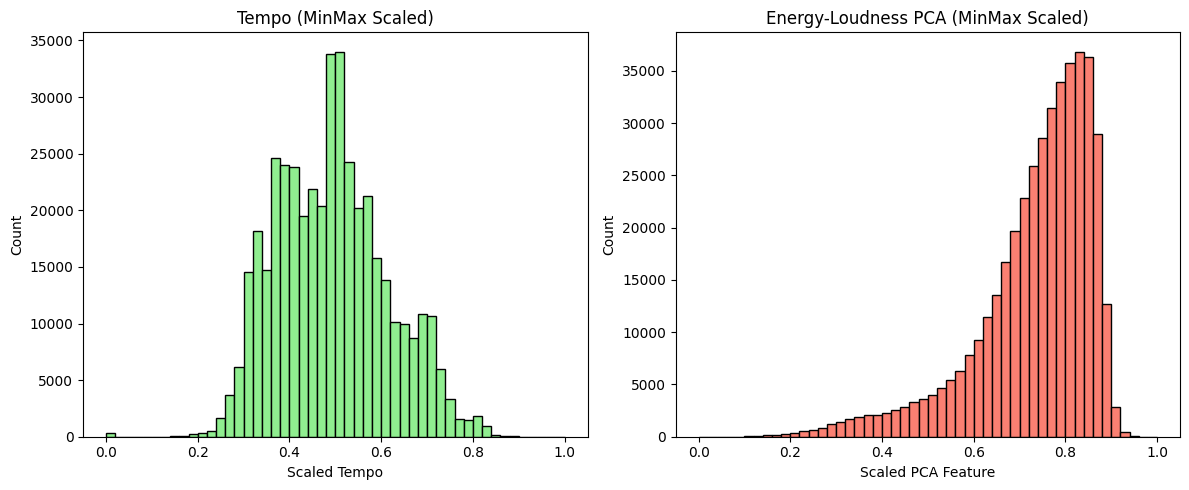

In [19]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(spotify_mil['tempo_scaled'], bins=50, color='lightgreen', edgecolor='black')
plt.title('Tempo (MinMax Scaled)')
plt.xlabel('Scaled Tempo')
plt.ylabel('Count')
plt.subplot(1, 2, 2)
plt.hist(spotify_mil['energy_loudness_pca_scaled'], bins=50, color='salmon', edgecolor='black')
plt.title('Energy-Loudness PCA (MinMax Scaled)')
plt.xlabel('Scaled PCA Feature')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

All the features selected for K-Means have now been successfully transformed to the (0, 1) range, and their distributions appear well-balanced without significant skew.

##2. Give more weights to important features

Personally, I think valence will significantly impact the mood and emotion of the song, so I decided to give this feature 2 times higher weight than other features.

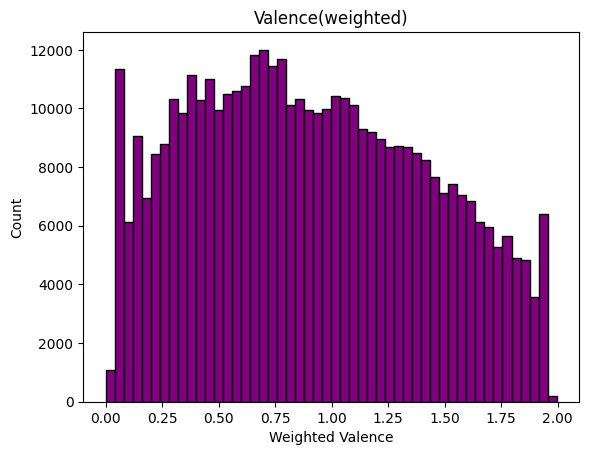

In [54]:
spotify_mil['valence'] = spotify_mil['valence'] * 2
plt.hist(spotify_mil['valence'], bins=50, color='purple', edgecolor='black')
plt.title('Valence(weighted)')
plt.xlabel('Weighted Valence')
plt.ylabel('Count')
plt.show()

#IV. K-means Model

In [56]:
features_kmeans = ['danceability', 'valence', 'tempo_scaled', 'energy_loudness_pca_scaled', 'acousticness', 'instrumentalness']

We don't need to scale the cluster data because we already used the processed features.

Intuitively, there should be at least 4 clusters for this task, including common moods such as chill, happy, sad, and intense. Therefore, I will try with minK = 4 then find the optimal number of clusters.

##1. Elbow Method

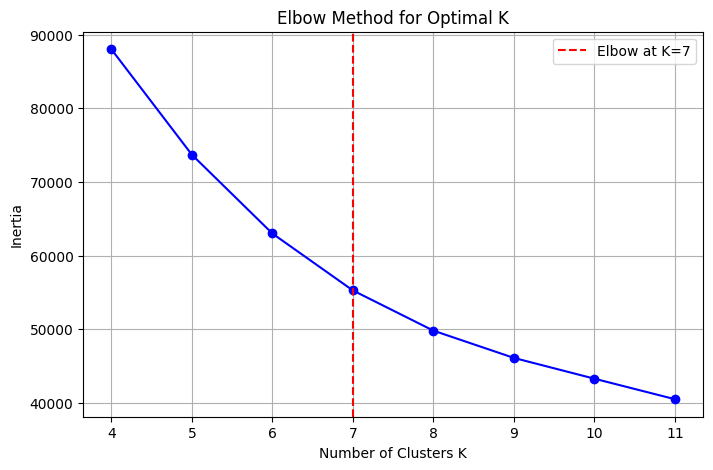

In [57]:
cluster_data = spotify_mil[features_kmeans].dropna()
inertia = []
K = range(4, 12)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(cluster_data)
    inertia.append(kmeans.inertia_)
knee = KneeLocator(K, inertia, curve="convex", direction="decreasing")
plt.figure(figsize=(8,5))
plt.plot(K, inertia, 'bo-')
plt.axvline(x=knee.knee, color='red', linestyle='--', label=f'Elbow at K={knee.knee}')
plt.xlabel('Number of Clusters K')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.grid()
plt.legend()
plt.show()

In [58]:
cluster_data

,danceability,valence,tempo_scaled,energy_loudness_pca_scaled,acousticness,instrumentalness
0,0.483,0.278,0.537886,0.619082,0.69400,0.000000
1,0.572,1.030,0.565207,0.656058,0.47700,0.000014
2,0.409,0.290,0.563796,0.555473,0.33800,0.000050
3,0.392,1.016,0.826392,0.608021,0.80700,0.000000
4,0.430,0.434,0.692947,0.805419,0.07260,0.019300
...,...,...,...,...,...,...
428784,0.801,1.610,0.451715,0.781792,0.26100,0.001030
428785,0.406,0.872,0.713522,0.623917,0.59000,0.605000
428786,0.914,0.986,0.475742,0.670016,0.45300,0.151000
428787,0.672,1.654,0.429334,0.761738,0.00242,0.112000


According to the Elbow Method, the optimal number of clusters to balance model complexity and cluster quality should be 7. However, as we can see from the plot, as the number of k increases, inertia (the sum of squared distances between each point and its cluster centroid) decreases as well => no peak value => more biased towards higher number of cluster. This method doesn’t measure cluster separation or how well clusters are separated from each other.

##2. Calinski-Harabasz Score

The Calinski-Harabasz score evaluates clustering quality based on the ratio of between-cluster dispersion to within-cluster dispersion, with higher values indicating more distinct and well-defined clusters. Therefore, to double check our cluster quality, this metric is useful.

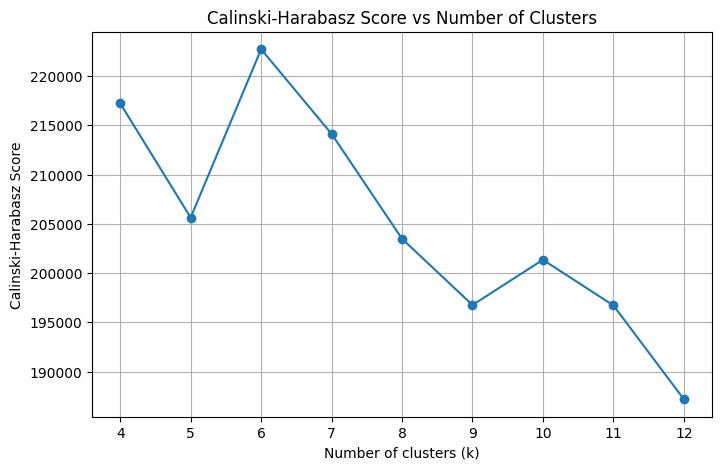

Optimal number of clusters (max CH score): 6


In [24]:
ch_scores = []
k_values = range(4, 13)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = kmeans.fit_predict(cluster_data)
    score = calinski_harabasz_score(cluster_data, labels)
    ch_scores.append(score)
plt.figure(figsize=(8, 5))
plt.plot(k_values, ch_scores, marker='o')
plt.title("Calinski-Harabasz Score vs Number of Clusters")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Calinski-Harabasz Score")
plt.grid(True)
plt.show()
optimal_k = k_values[np.argmax(ch_scores)]
print(f"Optimal number of clusters (max CH score): {optimal_k}")

Since Calinski-Harabasz is a more inclusive metric, I will choose k = 6 as the optimal number of cluster. I ran Silhouette score, the best metric in my opinion, for k = 6 and k = 7 as well, with 180k data points k = 6 is better, but when I tried to run with all data points, I couldn't get the output even after 3 hours.

## 3. Cluster Visualization

In [59]:
optimal_k = 6
kmeans = KMeans(n_clusters= optimal_k, random_state=42)
spotify_mil['cluster'] = kmeans.fit_predict(cluster_data)
labels = kmeans.labels_

In [60]:
pip install umap-learn

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


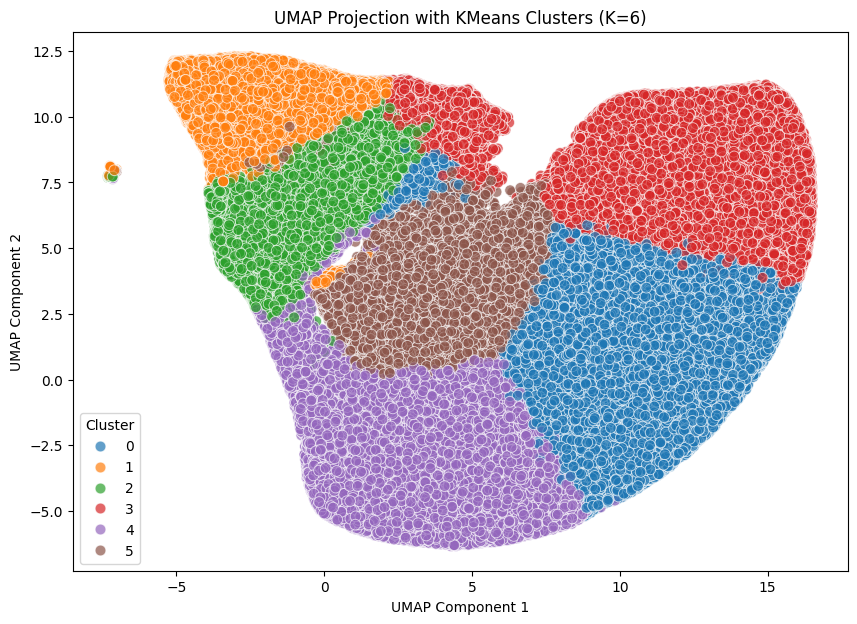

In [ ]:
import umap
reducer = umap.UMAP(n_components=2, n_neighbors = 30, min_dist = 0.15, random_state=42)
cluster_umap = reducer.fit_transform(cluster_data)
plt.figure(figsize=(10, 7))
sns.scatterplot(x=cluster_umap[:, 0], y=cluster_umap[:, 1], hue=labels, palette='tab10', s=60, alpha=0.7)
plt.title("UMAP Projection with KMeans Clusters (K=6)")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.legend(title="Cluster", loc='best')
plt.show()

For high-dimensional dataset and cluster visualization task, both tSNE and UMAP can preserve the global and local structure of each cluster. However, tSNE is more computationally expensive for huge dataset, that's why I chose UMAP (runtime ranges from 15 minutes to 25 minutes, so if you want to rerun it, please wait for a while).

##4. Typical features of each cluster

In [61]:
average = spotify_mil.groupby('cluster')[features_kmeans].agg('mean')
cluster_counts = spotify_mil['cluster'].value_counts().sort_index()
print(" Number of tracks per cluster:")
print(cluster_counts)
print("Average feature values per cluster:")
print(average)
top_n = 3
top_genres = (
    spotify_mil.groupby('cluster')['genre']
    .apply(lambda x: x.value_counts().nlargest(top_n))
    .reset_index(name='count')
)
print("Top 3 genres per cluster:")
print(top_genres)

 Number of tracks per cluster:
cluster
0    104149
1     35995
2     39907
3     98878
4     86250
5     58530
Name: count, dtype: int64
Average feature values per cluster:
         danceability   valence  tempo_scaled  energy_loudness_pca_scaled  \
cluster                                                                     
0            0.594397  1.065171      0.501802                    0.790136   
1            0.374964  0.367294      0.425755                    0.453023   
2            0.548392  0.583821      0.506202                    0.761430   
3            0.676808  1.612495      0.495147                    0.772919   
4            0.494336  0.469089      0.511909                    0.788342   
5            0.522651  0.642672      0.465432                    0.636406   

         acousticness  instrumentalness  
cluster                                  
0            0.115136          0.025903  
1            0.899481          0.862719  
2            0.087410          0.778819  


In [62]:
genre_cluster_pct = pd.crosstab(
    spotify_mil['genre'],
    spotify_mil['cluster'],
    normalize='index'
) * 100
genre_cluster_pct = genre_cluster_pct.round(2)
print(genre_cluster_pct)

cluster              0      1      2      3      4      5
genre                                                    
Acoustic         12.96  13.22   1.46  14.48   9.79  48.09
Blues            28.56   1.69   4.73  34.61  14.87  15.54
Classical Music   3.92  58.78   3.37   3.25   8.95  21.74
Composer         16.73   1.74   0.77  13.74  12.01  55.00
Country          35.35   0.15   0.15  27.47  17.58  19.30
Cultural Music   18.57   2.88   1.43  46.55   6.50  24.07
Electronic       20.79   2.24  25.49  20.62  26.18   4.68
French           22.67   7.27  11.18  25.21  15.14  18.52
Funk             27.77   0.93   8.61  45.57   9.98   7.15
German           27.88  12.15  11.28  17.55  23.02   8.11
Gospel           21.96   0.22   0.12  20.38  25.50  31.82
Groove           27.06   0.22  16.41  20.30  33.59   2.42
Hip-hop          39.91   0.07   0.89  28.85  24.37   5.91
House            24.37   0.38  31.04  18.72  24.10   1.39
Indian           25.04   2.46   1.81  31.64  10.46  28.58
Instrumental  

##5. Initial Cluster Label

- Cluster 0: All features are at medium level => bright, uplifting => good for road trip, for starting a day.
- Cluster 1: Low valence (or low positiveness), high instrumentalness and acousticness) => good for meditation, sleeping, studying, writing.
- Cluster 2: This cluster is the hardest to define. Second lowest valence (so not really has a positive vibe), high instrumental. According to the crosstable, most techno and house songs are in this group => hypnotic, rhythmic, groovy-driven songs. Maybe good for solo-dancing, idk.
- Cluster 3: High valence, high danceability => dancefloor, super energetic => good for working out/parties
- Cluster 4: High energy and loudness, high tempo, low acousticness and low instrumentalness => intense, aggressive, explosive (like rock and metal) => good for night drives/fighting game soundtracks
- Cluster 5: High acousticness, low valence => romantic/heartfelt/chill songs => good for cozy evenings/date nights

#V. Intuitively Model Evaluation

##1. Typical songs each cluster

In [63]:
centroids = kmeans.cluster_centers_
distances = np.linalg.norm(cluster_data.values - centroids[labels], axis=1)
spotify_mil = spotify_mil.loc[cluster_data.index].copy()
spotify_mil['centroid_distance'] = distances
top15_centroid = (
    spotify_mil.sort_values(['cluster', 'centroid_distance'])
            .groupby('cluster')
            .head(15)
            .reset_index(drop=True)
)
top15_centroid[['cluster', 'artist_name', 'track_name', 'genre', 'centroid_distance']]

,cluster,artist_name,track_name,genre,centroid_distance
0,0,Lucas & Steve,Give Me Your Love,House,0.032599
1,0,Bucie,Easy to Love,House,0.037679
2,0,Klingande,RIVA (Restart The Game) - Radio Edit,Pop,0.038390
3,0,кис-кис,молчи,Rock,0.038943
4,0,Nas,YKTV (feat. A Boogie Wit da Hoodie & YG),Metal,0.042436
...,...,...,...,...,...
85,5,Zaz,Dans ma rue,French,0.059238
86,5,Eslabon Armado,¿Donde Has Estado?,Sad,0.059945
87,5,BLÜ EYES,halcyon,Composer,0.061022
88,5,Roberta Flack,Killing Me Softly With His Song,Electronic,0.062297


In [64]:
# Check with some of my favorite artists, seems to be quite accurate in my opinion.
def check_cluster(artist_name):
    artist_songs = spotify_mil[
        spotify_mil['artist_name'].str.lower().str.contains(artist_name.lower(), na=False)]
    if artist_songs.empty:
        print(f"No songs found for artist matching: '{artist_name}'")
        return None
    return artist_songs[['artist_name', 'track_name', 'genre', 'cluster']].sort_values('cluster')
check_cluster('Laufey')

,artist_name,track_name,genre,cluster
214008,Laufey,Street by Street,Composer,5
214013,Laufey,Someone New,Composer,5
246983,Laufey,Like the Movies,Composer,5
246990,Laufey,Best Friend,Composer,5
246991,Laufey,Love to Keep Me Warm,Composer,5
246992,Laufey,I Wish You Love,Composer,5
247004,Laufey,Magnolia,Composer,5
247024,Laufey,Love Flew Away,Composer,5
247066,Laufey,James,Composer,5
282592,Laufey,Valentine,Composer,5


In [65]:
check_cluster('Cigarettes after sex')

,artist_name,track_name,genre,cluster
56991,Cigarettes After Sex,Affection,Relax,1
56990,Cigarettes After Sex,Keep On Loving You,Relax,1
98252,Cigarettes After Sex,Opera House,Relax,1
156067,Cigarettes After Sex,Pure,Relax,1
156059,Cigarettes After Sex,Kiss It Off Me,Relax,1
156062,Cigarettes After Sex,You're the Only Good Thing in My Life,Relax,1
156054,Cigarettes After Sex,Cry,Relax,1
156055,Cigarettes After Sex,Heavenly,Relax,1
156065,Cigarettes After Sex,Hentai,Relax,1
98257,Cigarettes After Sex,Flash,Relax,2


In [31]:
check_cluster('ryuichi sakamoto')

,artist_name,track_name,genre,cluster
1570,Ryuichi Sakamoto,Seven Samurai - ending theme,Relax,1
1646,Ryuichi Sakamoto,Merry Christmas Mr. Lawrence,Relax,1
57014,Ryuichi Sakamoto,The Revenant Main Theme,Relax,1
18301,Ryuichi Sakamoto,Germination,Relax,1
57088,Ryuichi Sakamoto,Glass and Buffalo Warrior Travel,Relax,1
...,...,...,...,...
98797,Ryuichi Sakamoto,fullmoon,Relax,5
1666,Ryuichi Sakamoto,The Last Emperor,Relax,5
57319,Ryuichi Sakamoto,Forbidden Colors,Relax,5
1604,Ryuichi Sakamoto,Happy End,Relax,5


This is actually interesting. For Ryuichi Sakamoto, there is only one song called 'disintegration' in cluster 4, and it does carry that eerie intensity, same vibe as Silent Hill or similar psychological horror soundscapes.

In [30]:
combination = spotify_mil[
    (spotify_mil['genre'] == 'Hip-hop') &
    (spotify_mil['cluster'] == 5)
][['artist_name', 'track_name', 'genre', 'cluster']]
print(combination)

           artist_name                                track_name    genre  \
10287      Frank Ocean                               Pilot Jones  Hip-hop   
10292       Mac Miller                        The Mourning After  Hip-hop   
10310   Kendrick Lamar  Sherane a.k.a Master Splinter’s Daughter  Hip-hop   
10311       Canserbero                              Maquiavélico  Hip-hop   
10354      Joey Bada$$                            Summer Knights  Hip-hop   
...                ...                                       ...      ...   
424116        MC Magic                             The Only Kiss  Hip-hop   
424142        MC Magic                        How Can I Love You  Hip-hop   
424158            Wale                  Don't Hold Your Applause  Hip-hop   
424166       J Alvarez                            Nada Es Eterno  Hip-hop   
424189           Lil B                                Motivation  Hip-hop   

        cluster  
10287         5  
10292         5  
10310         5  
103

Of course, the clusters aren’t perfect. For instance, I explored an unexpected combination: hip-hop songs in Cluster 5, which is generally associated with romantic or mellow moods. Interestingly, most of the tracks I sampled were indeed rap love songs or hip-hop with a melodic, romantic tone. However, there are exceptions — for example, “Sherane a.k.a Master Splinter’s Daughter” by Kendrick Lamar, which doesn't fit the romantic vibe at all.

In [32]:
features_catboost = spotify_mil[['track_name', 'artist_name', 'danceability', 'valence', 'tempo_scaled', 'energy_loudness_pca_scaled', 'acousticness', 'instrumentalness', 'cluster']]
features_catboost

,track_name,artist_name,danceability,valence,tempo_scaled,energy_loudness_pca_scaled,acousticness,instrumentalness,cluster
0,I Won't Give Up,Jason Mraz,0.483,0.278,0.537886,0.619082,0.69400,0.000000,5
1,93 Million Miles,Jason Mraz,0.572,1.030,0.565207,0.656058,0.47700,0.000014,0
2,Do Not Let Me Go,Joshua Hyslop,0.409,0.290,0.563796,0.555473,0.33800,0.000050,4
3,Fast Car,Boyce Avenue,0.392,1.016,0.826392,0.608021,0.80700,0.000000,5
4,Sky's Still Blue,Andrew Belle,0.430,0.434,0.692947,0.805419,0.07260,0.019300,4
...,...,...,...,...,...,...,...,...,...
428784,Around Ya feat. Fuel Fandango,Mo' Horizons,0.801,1.610,0.451715,0.781792,0.26100,0.001030,3
428785,Be With Me Now,GusGus,0.406,0.872,0.713522,0.623917,0.59000,0.605000,2
428786,Magnified Love,GusGus,0.914,0.986,0.475742,0.670016,0.45300,0.151000,0
428787,Eple 2003,Röyksopp,0.672,1.654,0.429334,0.761738,0.00242,0.112000,3


In [66]:
cluster_names = {
    0: "Driving All Night",
    1: "Focus Mix",
    2: "Feeling Bipolar(Ye)",
    3: "Dopamine Mix",
    4: "Clubbing All Night",
    5: "Chill Mix"
}
spotify_mil['cluster'] = spotify_mil['cluster'].map(cluster_names)

In [67]:
from google.colab import files
demo_app = spotify_mil[['track_name', 'artist_name', 'year', 'genre', 'popularity', 'cluster']]
demo_app.to_csv('demo_app.csv', index = False)
files.download('demo_app.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>